# Import Packages

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
sns.set_theme(style="white")
sns.color_palette("Set2")

import scipy.stats as stats
from scipy.interpolate import griddata

from EN_data_cleaning import clean_electric_nation_data, split_sessions

# Load In Data

In [8]:
CC_transaction_data = pd.read_excel('../data/electric_nation/CrowdChargeTransactions.xlsx', sheet_name='Transaction Data')
GF_transaction_data = pd.read_excel('../data/electric_nation/GreenFluxTransactions.xlsx', sheet_name='Transaction Data')
install_data = pd.read_excel('../data/electric_nation/ChargerInstall.xlsx', sheet_name='data')

# Clean Data

In [9]:
session_df, install_df = clean_electric_nation_data(CC_transaction_data, GF_transaction_data, install_data)

# Analyse And Classify Battery Capacity

<Axes: >

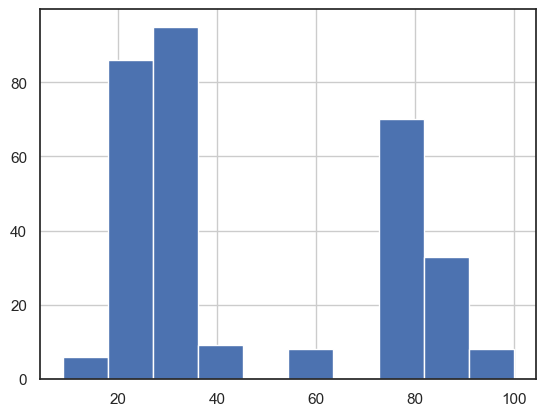

In [10]:
install_df[install_df['PIVType'] == 'BEV'].CarkWh.hist()

In [11]:
session_df['BatterySize'] = 0 # Small 
session_df.loc[session_df.CarkWh >= 50, 'BatterySize'] = 1 # Large

In [12]:
session_df.head()

,TransactionID,ChargerID,ParticipantID,StartTime,StopTime,GroupID,Trial,AdjustedStartTime,AdjustedStopTime,SessionDurationM,...,ChargerInstallDate,CarMake,CarModel,PIVType,CarkW,CarkWh,ApproxChargingDurationH,ApproxChargingDurationM,ApproxEndCharge,BatterySize
0,110244,36001617,EN1024,2017-07-04 11:18:00,2017-07-04 15:37:00,CC0001,1.0,2017-07-04 12:18:00,2017-07-04 16:37:00,259,...,2017-03-28,BMW,i3 BEV,BEV,7.0,33.0,4.012857,241,2017-07-04 16:19:00,0
1,106324,36000317,EN1156,2017-07-04 15:22:00,2017-07-04 17:18:00,CC0001,1.0,2017-07-04 16:22:00,2017-07-04 18:18:00,116,...,2017-03-27,BMW,i3 REX,REX,7.0,33.0,0.154286,9,2017-07-04 16:31:00,0
2,112104,36002117,EN1115,2017-07-04 16:36:00,2017-07-05 07:18:00,CC0001,1.0,2017-07-04 17:36:00,2017-07-05 08:18:00,882,...,2017-03-24,BMW,i8,PHEV,3.6,7.1,0.825000,50,2017-07-04 18:26:00,0
3,106325,36000317,EN1156,2017-07-04 19:12:00,2017-07-05 15:17:00,CC0001,1.0,2017-07-04 20:12:00,2017-07-05 16:17:00,1205,...,2017-03-27,BMW,i3 REX,REX,7.0,33.0,0.400000,24,2017-07-04 20:36:00,0
4,109032,36001317,EN1131,2017-07-05 11:46:00,2017-07-05 18:00:00,CC0001,1.0,2017-07-05 12:46:00,2017-07-05 19:00:00,374,...,2017-03-29,Tesla,Model S,BEV,7.0,75.0,2.622857,157,2017-07-05 15:23:00,1


# Split Data

In [13]:
# session_df_split = split_sessions(session_df)

In [14]:
bev_df = session_df[session_df.PIVType == 'BEV']

In [15]:
phev_df = session_df[session_df.PIVType == 'PHEV']

# Create the Working Dataset

## Find a suitable Date Range

In [16]:
# print('First BEV session: ' + str(bev_df.AdjustedStartTime.iloc[0].floor(freq='D') - dt.timedelta(days=1)))
# print('First PHEV session: ' + str(phev_df.AdjustedStartTime.iloc[0].floor(freq='D') - dt.timedelta(days=1)))
# print('Last BEV session: ' + str(bev_df.AdjustedStopTime.iloc[-1].ceil(freq='D') - dt.timedelta(hours=1) - dt.timedelta(days=3)))
# print('Last BEV session: ' + str(phev_df.AdjustedStopTime.iloc[-1].ceil(freq='D') - dt.timedelta(hours=1) - dt.timedelta(days=3)))

We will use the date range that is the union of BEV and PHEV activity (i.e. they both share the same start time, but since the last BEV session is 3 weeks prior to the lest PHEV session, we will use the former as our limit for the date range.)

In [17]:
def calculate_dt_range(df):
    start = str(df.AdjustedStartTime.iloc[0].floor(freq='D'))
    end = str(df.AdjustedStopTime.iloc[-1].ceil(freq='D') - dt.timedelta(hours=1))
    dt_range = pd.date_range(start, end, freq = 'H')
    return dt_range

In [18]:
dt_range = calculate_dt_range(session_df)
dt_range

DatetimeIndex(['2017-07-04 00:00:00', '2017-07-04 01:00:00',
               '2017-07-04 02:00:00', '2017-07-04 03:00:00',
               '2017-07-04 04:00:00', '2017-07-04 05:00:00',
               '2017-07-04 06:00:00', '2017-07-04 07:00:00',
               '2017-07-04 08:00:00', '2017-07-04 09:00:00',
               ...
               '2018-12-27 14:00:00', '2018-12-27 15:00:00',
               '2018-12-27 16:00:00', '2018-12-27 17:00:00',
               '2018-12-27 18:00:00', '2018-12-27 19:00:00',
               '2018-12-27 20:00:00', '2018-12-27 21:00:00',
               '2018-12-27 22:00:00', '2018-12-27 23:00:00'],
              dtype='datetime64[ns]', length=13008, freq='H')

In [19]:
# start = str(session_df.AdjustedStartTime.iloc[0].floor(freq='D') - dt.timedelta(days=1))
# end = str(session_df.AdjustedStopTime.iloc[-1].ceil(freq='D') - dt.timedelta(hours=1) - dt.timedelta(days=2))
# dt_range = pd.date_range(start, end, freq = 'H')
# dt_range

## Number of EVs charging

In [20]:
def count_n_charging(df, dt_range, BatterySize):
    N_charging = []
    for d in dt_range:
        N_charging.append(len(df[(df.AdjustedStartTime <= d) & (df.ApproxEndCharge >= d) & (df.BatterySize == BatterySize)]))
    return np.array(N_charging)

In [21]:
N_small_bev_charging = count_n_charging(bev_df, dt_range, BatterySize=0) # Small Battery BEVs
N_large_bev_charging = count_n_charging(bev_df, dt_range, BatterySize=1) # Large Battery BEVs
N_phev_charging = count_n_charging(phev_df, dt_range, BatterySize=0) # (Small Battery) PHEVs

In [22]:
len(N_small_bev_charging)

13008

In [23]:
len(N_large_bev_charging)

13008

In [24]:
len(N_phev_charging)

13008

## Month

In [25]:
month = dt_range.month.astype('category')
month

CategoricalIndex([ 7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
                  ...
                  12, 12, 12, 12, 12, 12, 12, 12, 12, 12],
                 categories=[1, 2, 3, 4, ..., 9, 10, 11, 12], ordered=False, dtype='category', length=13008)

## Weekday

In [26]:
day = dt_range.weekday.astype('category')
day

CategoricalIndex([1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                  ...
                  3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
                 categories=[0, 1, 2, 3, 4, 5, 6], ordered=False, dtype='category', length=13008)

## Time

In [27]:
t = dt_range.hour.astype('category')
t

CategoricalIndex([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9,
                  ...
                  14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
                 categories=[0, 1, 2, 3, ..., 20, 21, 22, 23], ordered=False, dtype='category', length=13008)

## Number of Active EVs

I Need to redo how I was computing this for robustness and better accuracy. I need to use a moving window to count the number of unique users charging their vehicles in the last week.

In [28]:
def count_n_active(df, dt_range, BatterySize):
    N_active = []
    for i in range(len(dt_range)):
        end = dt_range[i]
        start = dt_range[i] - dt.timedelta(weeks=1)
        N_active.append(len(df[(df.AdjustedStartTime <= end) & (df.ApproxEndCharge >= start) & (df.BatterySize == BatterySize)]))
    return np.array(N_active)

In [29]:
N_small_bev_active = count_n_active(bev_df, dt_range, BatterySize=0)
N_large_bev_active = count_n_active(bev_df, dt_range, BatterySize=1)
N_phev_active = count_n_active(phev_df, dt_range, BatterySize=0)

In [30]:
len(N_small_bev_active)

13008

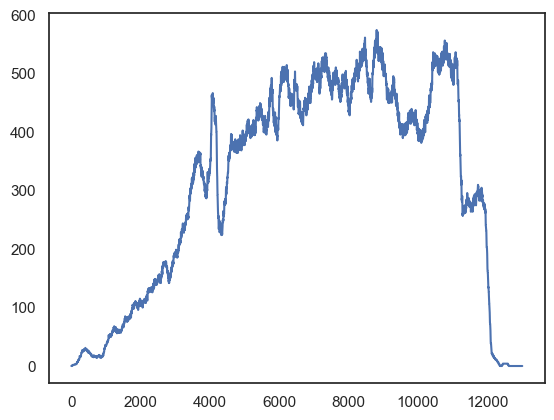

In [31]:
plt.plot(N_small_bev_active)

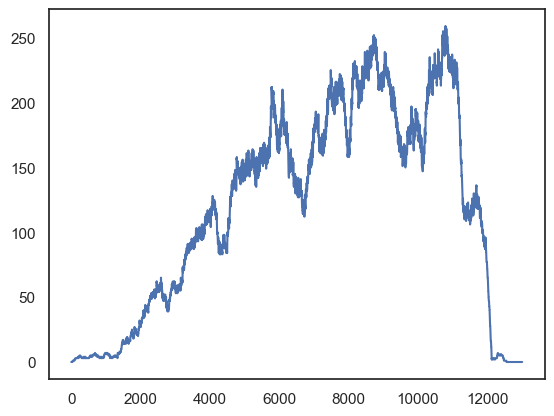

In [32]:
plt.plot(N_large_bev_active)

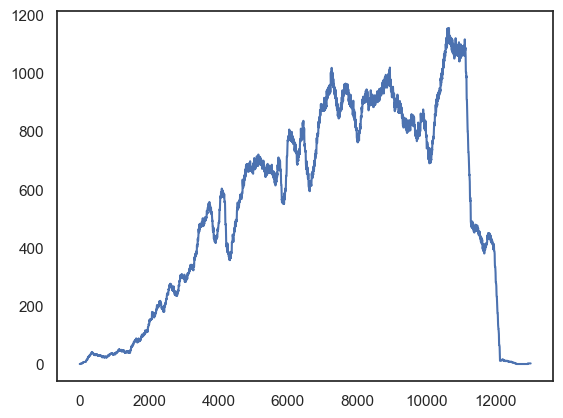

In [33]:
plt.plot(N_phev_active)

In [34]:
def calculate_n_not_charging(n_active, n_charging):
    n_not_charging = n_active - n_charging
    n_not_charging = n_not_charging.astype('int32')
    return n_not_charging

In [35]:
N_small_bev_not_charging = calculate_n_not_charging(N_small_bev_active, N_small_bev_charging)
N_large_bev_not_charging = calculate_n_not_charging(N_large_bev_active, N_large_bev_charging)
N_phev_not_charging = calculate_n_not_charging(N_phev_active, N_phev_charging)

## The DataFrame

In [36]:
small_bev_data = {
    'DateTime': dt_range,
    'Charging': N_small_bev_charging,
    'Not_charging': N_small_bev_not_charging,
    'Month': month,
    'Day': day,
    'Time': t,
    'N_active': N_small_bev_active,
    'PIV': 'BEV',
    'Large_battery': 0
}

large_bev_data = {
    'DateTime': dt_range,
    'Charging': N_large_bev_charging,
    'Not_charging': N_large_bev_not_charging,
    'Month': month,
    'Day': day,
    'Time': t,
    'N_active': N_large_bev_active,
    'PIV': 'BEV',
    'Large_battery': 1
}

phev_data = {
    'DateTime': dt_range,
    'Charging': N_phev_charging,
    'Not_charging': N_phev_not_charging,
    'Month': month,
    'Day': day,
    'Time': t,
    'N_active': N_phev_active,
    'PIV': 'PHEV',
    'Large_battery': 0
}

In [37]:
df = pd.concat([pd.DataFrame(data = small_bev_data), pd.DataFrame(data = large_bev_data), pd.DataFrame(data = phev_data)], ignore_index=True)

In [38]:
df['PIV'] = df['PIV'].astype('category')

In [39]:
df.head()

,DateTime,Charging,Not_charging,Month,Day,Time,N_active,PIV,Large_battery
0,2017-07-04 00:00:00,0,0,7,1,0,0,BEV,0
1,2017-07-04 01:00:00,0,0,7,1,1,0,BEV,0
2,2017-07-04 02:00:00,0,0,7,1,2,0,BEV,0
3,2017-07-04 03:00:00,0,0,7,1,3,0,BEV,0
4,2017-07-04 04:00:00,0,0,7,1,4,0,BEV,0


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39024 entries, 0 to 39023
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   DateTime       39024 non-null  datetime64[ns]
 1   Charging       39024 non-null  int64         
 2   Not_charging   39024 non-null  int32         
 3   Month          39024 non-null  category      
 4   Day            39024 non-null  category      
 5   Time           39024 non-null  category      
 6   N_active       39024 non-null  int64         
 7   PIV            39024 non-null  category      
 8   Large_battery  39024 non-null  int64         
dtypes: category(4), datetime64[ns](1), int32(1), int64(3)
memory usage: 1.5 MB


In [41]:
df

,DateTime,Charging,Not_charging,Month,Day,Time,N_active,PIV,Large_battery
0,2017-07-04 00:00:00,0,0,7,1,0,0,BEV,0
1,2017-07-04 01:00:00,0,0,7,1,1,0,BEV,0
2,2017-07-04 02:00:00,0,0,7,1,2,0,BEV,0
3,2017-07-04 03:00:00,0,0,7,1,3,0,BEV,0
4,2017-07-04 04:00:00,0,0,7,1,4,0,BEV,0
...,...,...,...,...,...,...,...,...,...
39019,2018-12-27 19:00:00,0,2,12,3,19,2,PHEV,0
39020,2018-12-27 20:00:00,0,2,12,3,20,2,PHEV,0
39021,2018-12-27 21:00:00,0,2,12,3,21,2,PHEV,0
39022,2018-12-27 22:00:00,0,2,12,3,22,2,PHEV,0


## Save Dataset as .csv

In [42]:
df.to_csv('../data/hourly_data.csv', index=False)